## <a name="top"></a>Understanding Vehicle Fuel Economy (MPG) Predictions

*Elliot Coyne and Sammi Rosser, HSMA Trainers*

In this Notebook we will try to understand how a trained [XGBoost](https://xgboost.readthedocs.io/en/stable/) model makes it's predictions about vehicle fuel efficiency a.k.a. miles per gallon (MPG).

Jump to the relevant section
- [Library Imports](#imports)
- [Data Import](#data)
- [Building Model](#building_model)
- [shap.KernelExplainer](#shap_ke)
- [shap.Explainer](#shap_exp)
- [Summary Plot - Feature Importance](#summ_fi)
- [Dependence Plot](#dep_plot)
- [Visualising a Single Prediction - Waterfall Plot](#waterfall)
- [Force Plot](#force)

### <a name="imports"></a>Library Imports

In [68]:
import pandas as pd
import numpy as np
from numpy import absolute
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sklearn
print("Scikit-Learn Version : {}".format(sklearn.__version__))

import shap
from shap import Explanation
print("SHAP Version : {}".format(shap.__version__))

# JavaScript Important for the interactive charts later on
shap.initjs()

Scikit-Learn Version : 1.4.2
SHAP Version : 0.44.1


### <a name="data"></a>Data Import

In [69]:
data = pd.read_csv('../datasets/auto-mpg.csv')
data = data.loc[(data['horsepower']!='?')]
data['horsepower'] = data['horsepower'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int32  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(3), int32(1), int64(4), object(1)
memory usage: 29.1+ KB


In [70]:
X = data.drop(['mpg', 'car name'], axis=1)
y = data['mpg']

In [71]:
print(X.shape)
print(y.shape)

(392, 7)
(392,)


### <a name="building_model"></a>Building Model

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

In [73]:
# create an xgboost regression model
model = xgb.XGBRegressor(n_estimators=100)

# fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [74]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.040 (0.270)


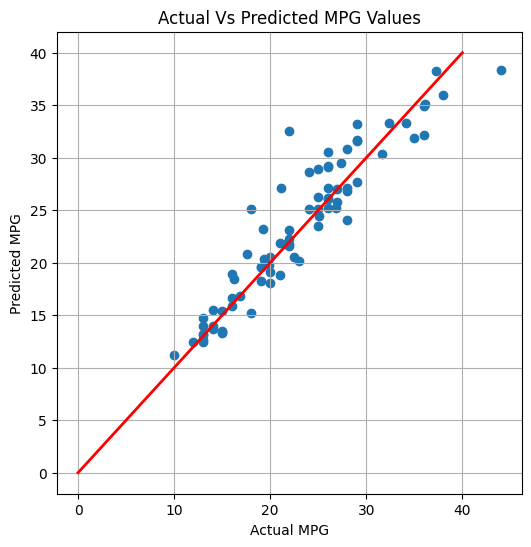

In [75]:
# Check Actual Vs Predictions
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot points
x_points = y_test
y_points = model.predict(X_test)

ax.scatter(x_points, y_points)
ax.set_title('Actual Vs Predicted MPG Values')
ax.set_ylabel('Predicted MPG')
ax.set_xlabel('Actual MPG')

ax.plot([0, 40],
       [0, 40],
       color='r',
       linestyle='-',
       linewidth=2)

plt.grid()
plt.show()

### <a name="shap_ke"></a>shap.KernelExplainer

The below is taken from the documentation, available [here](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html)

*"Uses Shapley values to explain any machine learning model or python function.*

*This is the primary explainer interface for the SHAP library. It takes any combination of a model and masker and returns a callable subclass object that implements the particular estimation algorithm that was chosen."*


For the shap.Explainer the first parameter must meet the following requirement and therefore must be `model.predict` "User supplied function that takes a matrix of samples (# samples x # features) and computes a the output of the model for those samples. The output can be a vector (# samples) or a matrix (# samples x # model outputs)."

We are using `TreeExplainer` as it's generally faster with tree-based models and avoids some issues that can come with using `KernelExplainer`. 

In [95]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)

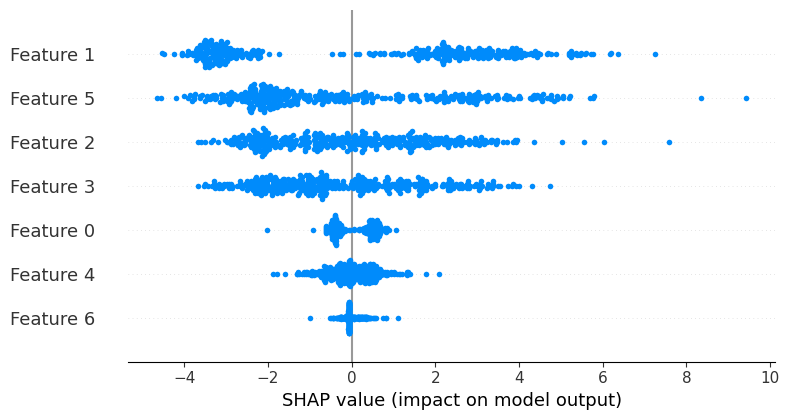

In [96]:
# You can then use `shap.summary_plot`
# however if you don't specify the `features` arguement
# then you will get the below...
shap.summary_plot(shap_values)

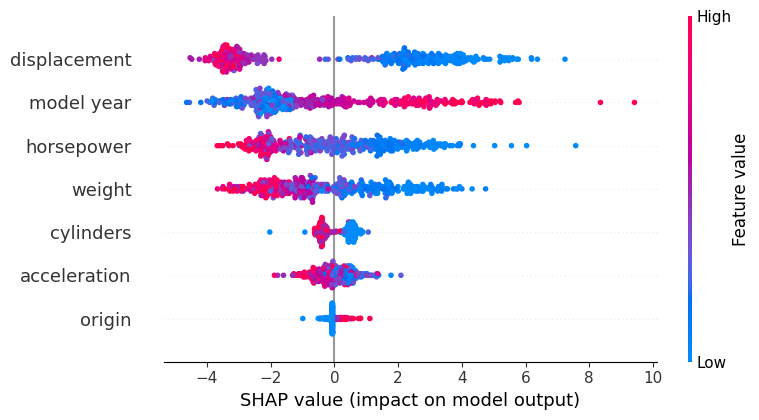

In [93]:
# Once added in, you get the feature names (left) and values (right)
shap.summary_plot(shap_values, X)

### <a name="shap_exp"></a>shap.Explainer

The below is taken from the documentation, available [here](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.Explainer.html)

*"Uses Shapley values to explain any machine learning model or python function.*

*This is the primary explainer interface for the SHAP library. It takes any combination of a model and masker and returns a callable subclass object that implements the particular estimation algorithm that was chosen."*

In [94]:
# View the shap values
shap_values

array([[-0.42742133, -2.977171  , -2.3533642 , ...,  0.2513931 ,
        -1.7955452 , -0.08710288],
       [-0.53395665, -3.4035988 , -2.3366275 , ...,  0.9442768 ,
        -1.7016076 , -0.06605496],
       [-0.39760754, -2.800151  , -1.5366807 , ...,  1.3267298 ,
        -1.3671033 , -0.07916196],
       ...,
       [ 0.6424927 ,  2.0492957 ,  1.4011536 , ..., -0.58045197,
         4.2552195 , -0.21738222],
       [ 0.4589314 ,  1.582175  ,  1.2783843 , ..., -0.5054588 ,
         3.8523345 , -0.24726829],
       [ 0.343197  ,  2.055402  ,  1.7089833 , ..., -0.05041602,
         4.9030457 , -0.23797593]], dtype=float32)

In [97]:
# Obtain shap interaction values
shap_interaction_values = explainer.shap_interaction_values(X)
shap_interaction_values

array([[[-4.19715345e-01,  7.82883167e-03, -5.34574986e-02, ...,
         -5.74257746e-02, -1.14314973e-01,  1.57726333e-02],
        [ 7.82884657e-03, -4.30214739e+00,  4.50763285e-01, ...,
          8.29664767e-02, -6.29630089e-02,  1.58539526e-02],
        [-5.34575880e-02,  4.50762391e-01, -2.58196616e+00, ...,
         -1.58263490e-01,  1.34563088e-01,  1.13851093e-02],
        ...,
        [-5.74257523e-02,  8.29665661e-02, -1.58264160e-01, ...,
          1.10317245e-01,  2.28243828e-01, -1.08196922e-02],
        [-1.14314914e-01, -6.29627705e-02,  1.34564281e-01, ...,
          2.28244171e-01, -2.03641510e+00,  1.57242827e-02],
        [ 1.57726258e-02,  1.58541203e-02,  1.13848448e-02, ...,
         -1.08196661e-02,  1.57242417e-02, -1.29801393e-01]],

       [[-4.39185679e-01, -9.69648361e-04, -1.57002211e-02, ...,
         -4.34967279e-02, -9.71596837e-02,  1.57726314e-02],
        [-9.69678164e-04, -4.30600262e+00,  2.95591235e-01, ...,
          3.30500007e-02, -1.05677366e

### <a name="summ_fi"></a>[Summary Plot - Feature Importance](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=summary%20plot)

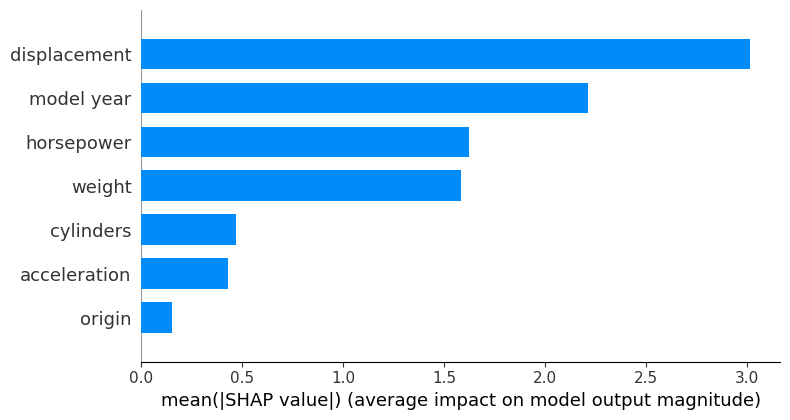

In [99]:
shap.summary_plot(shap_values,
                  X,
                  plot_type="bar")

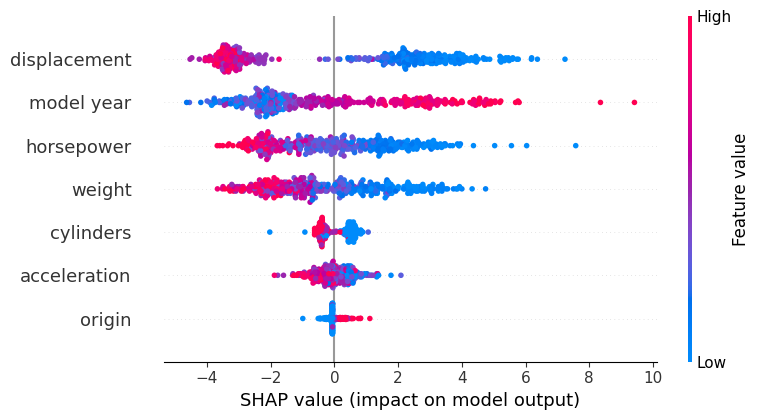

In [100]:
# Summary - Beeswarm plot
shap.summary_plot(shap_values,
                  X)

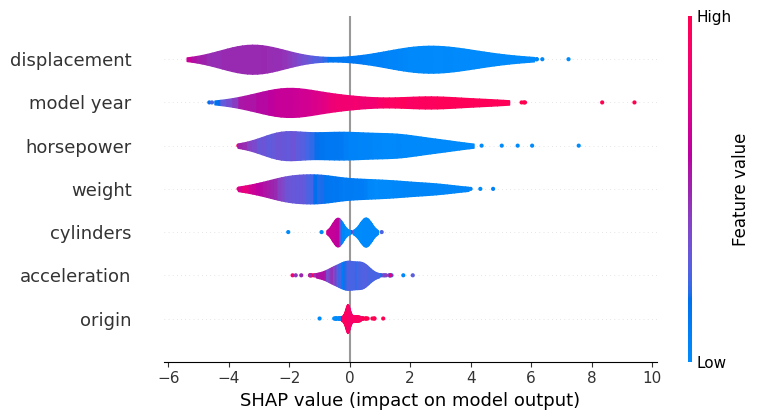

In [101]:
# Summary - Violin plot
shap.summary_plot(shap_values,
                  X,
                  plot_type="violin")

### <a name="dep_plot"></a>[Dependence Plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.dependence_plot.html)

*"Create a SHAP dependence plot, colored by an interaction feature.*

*Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects. Grey ticks along the y-axis are data points where the feature’s value was NaN."*

In [102]:
# Lets see the features and respective index numbers
for e, i in enumerate(X_test.columns):
    print(f"{e} - {i}")

0 - cylinders
1 - displacement
2 - horsepower
3 - weight
4 - acceleration
5 - model year
6 - origin


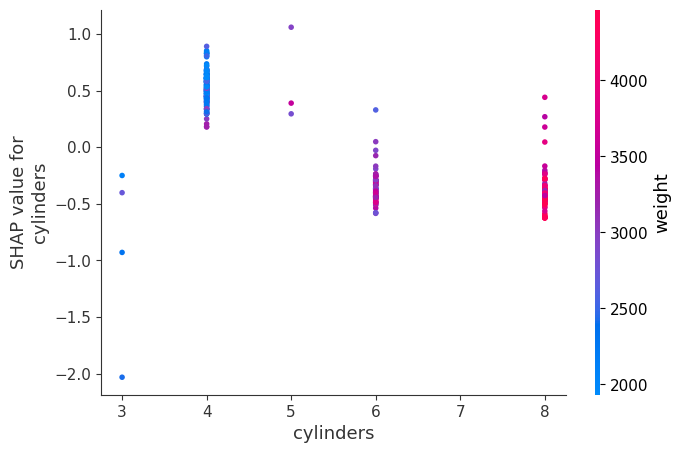

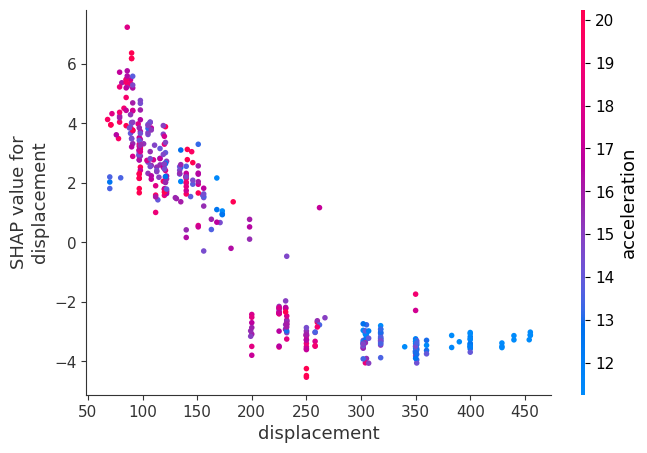

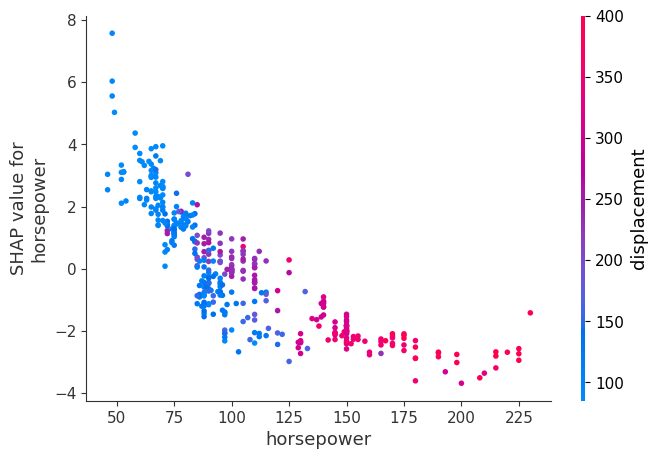

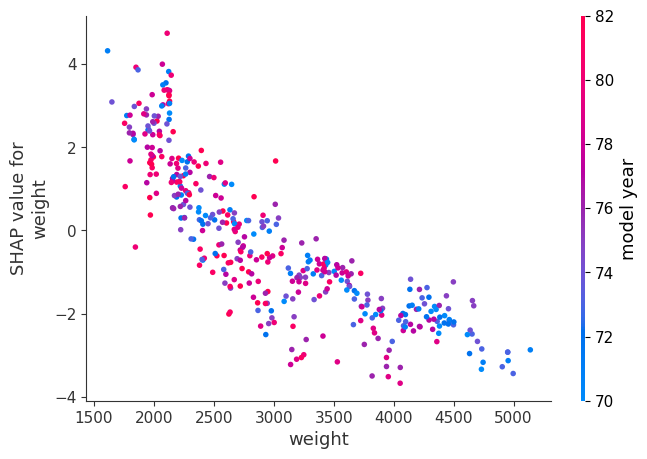

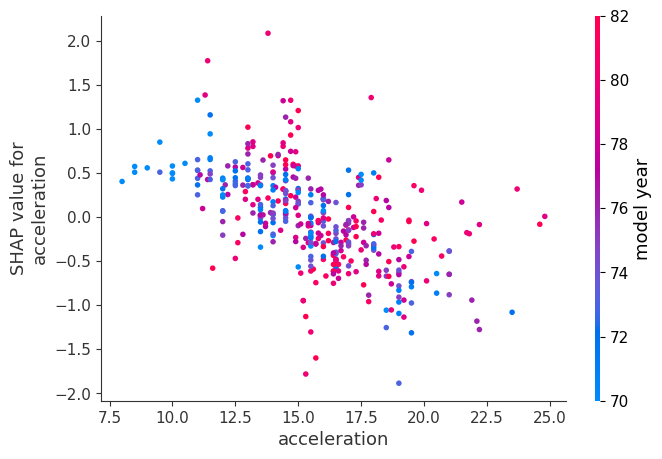

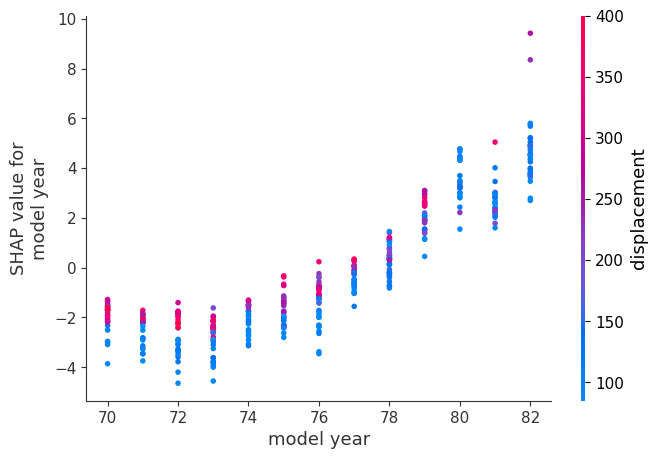

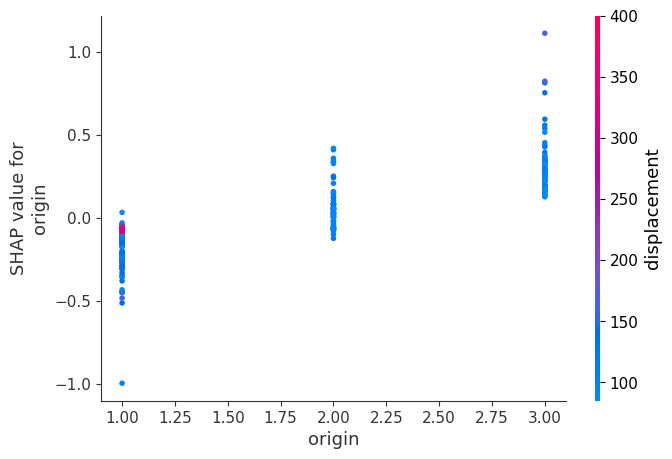

In [103]:
# Now to create a dependence plot for each...
# Remember - Y-axis - is SHAP value for respective feature value
# X-axis - is the freature's value
for e, i in enumerate(X.columns):
    shap.dependence_plot(e, shap_values, X)

### <a name="waterfall"></a>Visualising a Single Prediction - [Waterfall Plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.waterfall_plot.html)

You can use the `waterfall_plot` method to inpect a single prediction.
To use this you need to use the shap.Explanation

In [107]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

In [108]:
print(type(shap_values))

# note the different attributes i.e. values, base_values, etc
shap_values

<class 'shap._explanation.Explanation'>


.values =
array([[-0.36423585, -2.08156505, -2.46760835, ...,  0.35580785,
        -2.14063371, -0.19851738],
       [-0.39217939, -2.52749013, -2.83166984, ...,  1.3191638 ,
        -2.18766041, -0.1160585 ],
       [-0.31645806, -2.07288202, -1.76819541, ...,  1.62330182,
        -1.63124927, -0.19095915],
       ...,
       [ 0.3012672 ,  0.04250504,  1.25237213, ..., -0.47802747,
         5.20862813, -0.26892327],
       [ 0.11849914, -0.28857898,  1.10677909, ..., -0.59252805,
         4.84618759, -0.30359548],
       [ 0.04373785,  0.08472735,  1.64271687, ..., -0.21505879,
         5.9324121 , -0.2921266 ]])

.base_values =
array([24.03610803, 24.03610803, 24.03610803, 24.03610803, 24.03610803,
       24.03610803, 24.03610803, 24.03610803, 24.03610803, 24.03610803,
       24.03610803, 24.03610803, 24.03610803, 24.03610803, 24.03610803,
       24.03610803, 24.03610803, 24.03610803, 24.03610803, 24.03610803,
       24.03610803, 24.03610803, 24.03610803, 24.03610803, 24.03610803,
 

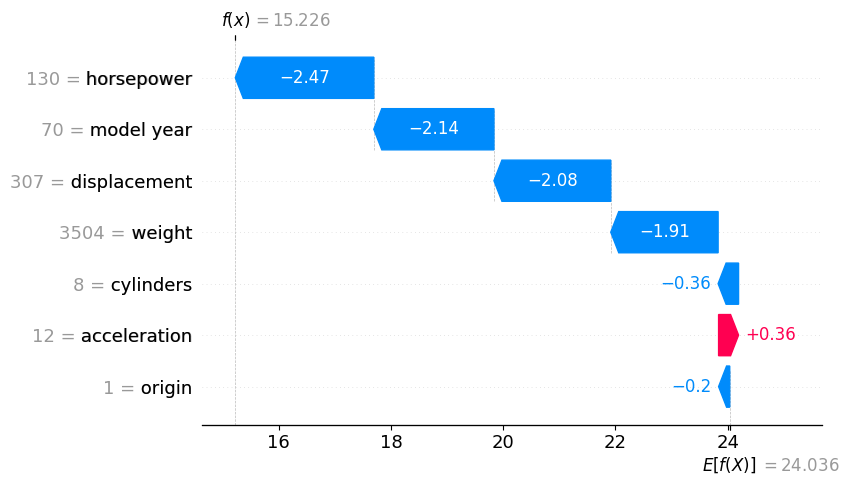

In [141]:
# idx of value to check
idx = 0
shap.plots.waterfall(shap_values[idx])

### <a name="force"></a>[Force Plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.force_plot.html)

*"Visualize the given SHAP values with an additive force layout."*

In [126]:
# e = shap.Explainer(model, X)

explainer.expected_value

24.036108025182738

In [127]:
# See how the predicted value above compares to average predicted value below
y_pred = model.predict(X)
y_pred.mean()

23.537613

In [128]:
shap_values[0,:]

.values =
array([-0.36423585, -2.08156505, -2.46760835, -1.91300594,  0.35580785,
       -2.14063371, -0.19851738])

.base_values =
24.036108025182738

.data =
array([8.000e+00, 3.070e+02, 1.300e+02, 3.504e+03, 1.200e+01, 7.000e+01,
       1.000e+00])

In [129]:
X.iloc[0,:]

cylinders          8.0
displacement     307.0
horsepower       130.0
weight          3504.0
acceleration      12.0
model year        70.0
origin             1.0
Name: 0, dtype: float64

In [138]:
# Inspecting a single record using `shap.force_plot`
idx = 0
# shap.force_plot(e, # base_value i.e. expected value i.e. mean of predictions
#                 shap_values[idx,:], # shap_values i.e. matrix of SHAP values
#                 X.iloc[idx,:]) # features i.e. should be the same as shap_values, above

shap.plots.force(shap_values[idx])

In [140]:
# Multiple values
# Interactive plot with 2 different drop downs - left and top
# shap.force_plot(e.expected_value,
#                 shap_values,
#                 X_test)

shap.plots.force(shap_values)

#### References Used
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html?highlight=waterfall
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Fitting%20a%20Linear%20Simulation%20with%20XGBoost.html